# Integrated Gradients Explainability in Turkish Text Classification

## Imports and Parameters

In [1]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:50%; margin-right:auto; margin-left:0;"
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle
from tqdm.notebook import tqdm

from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from ig_utils import *
from load_models import prepare_models

<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_ig = config["path_ig"]
thresholds = config["thresholds"]
only_load = config["only_load"]

path_reports = config["path_reports"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

,Parameter,Value
0,path_ttc4900,Data/TTC_4900/
1,path_tr_news,Data/TR_News/
2,path_interpress,Data/Interpress/
3,path_tc32,Data/TC32/
4,path_bert_model_ttc4900,Models/bertturk_text_classification_fine_tuned_ttc4900
5,path_bert_model_tr_news,Models/bertturk_text_classification_fine_tuned_tr_news
6,path_bert_model_interpress,Models/bertturk_text_classification_fine_tuned_interpress
7,path_bert_model_tc32,Models/bertturk_text_classification_fine_tuned_tc32
8,path_tbt_model_ttc4900,Models/turkishbertweet_text_classification_fine_tuned_ttc4900
9,path_tbt_model_tr_news,Models/turkishbertweet_text_classification_fine_tuned_tr_news


## Load Datasets

In [3]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## Integrated Gradients Explainability

In [4]:
all_exp_results = pd.DataFrame(columns=["Cl Acc", "ECS FT", "ECS TT", "ORC (+)", "ORC (-)"])

### BERTTurk

#### Inference on Full Text

In [5]:
# Load BERTTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

Error caught was: No module named 'triton'



'bertturk_text_classification_fine_tuned_ttc4900' is loaded.

'bertturk_text_classification_fine_tuned_tr_news' is loaded.

'bertturk_text_classification_fine_tuned_interpress' is loaded.

'bertturk_text_classification_fine_tuned_tc32' is loaded.


In [6]:
path_classification_results = "Data/Classification_Results/BERTTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

In [7]:
num_samples = 50

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

#### TTC4900

In [8]:
model_ttc4900_output = create_model_output_function(bert_model_ttc4900)
lig_ttc4900 = LayerIntegratedGradients(model_ttc4900_output, bert_model_ttc4900.bert.embeddings)

ttc4900_bert_results = {}

for threshold in thresholds:
    
    ig_values_ttc, score_vis_ttc = apply_ig(path_ig, 
                                            ttc4900_test, 
                                            lig_ttc4900, 
                                            bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                            f"ig_and_scores_ttc_{threshold}_bert",
                                            device,
                                            only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(ig_values_ttc, bert_tokenizer_ttc4900, threshold)
    
    ig_values_ttc_short, score_vis_ttc_short = apply_ig(path_ig, 
                                                        top_tokens_ttc4900, 
                                                        lig_ttc4900,
                                                        bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                                        f"ig_and_scores_ttc_short_{threshold}_bert", 
                                                        device,
                                                        only_load=only_load)
    
    ttc4900_bert_result = compare_probs(ttc4900_test,
                                        bert_full_text_preds_ttc4900,
                                        top_tokens_ttc4900,
                                        None,
                                        bert_model_ttc4900, bert_tokenizer_ttc4900,
                                        id2label=bert_id2label_ttc4900,
                                        device=device)

    ttc4900_bert_results[threshold] = (score_vis_ttc, score_vis_ttc_short, ttc4900_bert_result)
    
    clear_gpu_memory()
    
    show(ttc4900_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_ttc_0.5_bert' file length: 50
'ig_and_scores_ttc_short_0.5_bert' file length: 50


'ig_and_scores_ttc_0.6_bert' file length: 50
'ig_and_scores_ttc_short_0.6_bert' file length: 50


'ig_and_scores_ttc_0.7_bert' file length: 50
'ig_and_scores_ttc_short_0.7_bert' file length: 50


In [9]:
sample_no = 28

viz.visualize_text([ttc4900_bert_results[0.6][0][sample_no]])
viz.visualize_text([ttc4900_bert_results[0.6][1][sample_no]])
display()


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.967
Explanations Contribution Score (ECS) of Top Tokens :  0.874
Overall Relative Change (ORC) positive changes      :  0.256 %
Overall Relative Change (ORC) negative changes      : -11.777 %


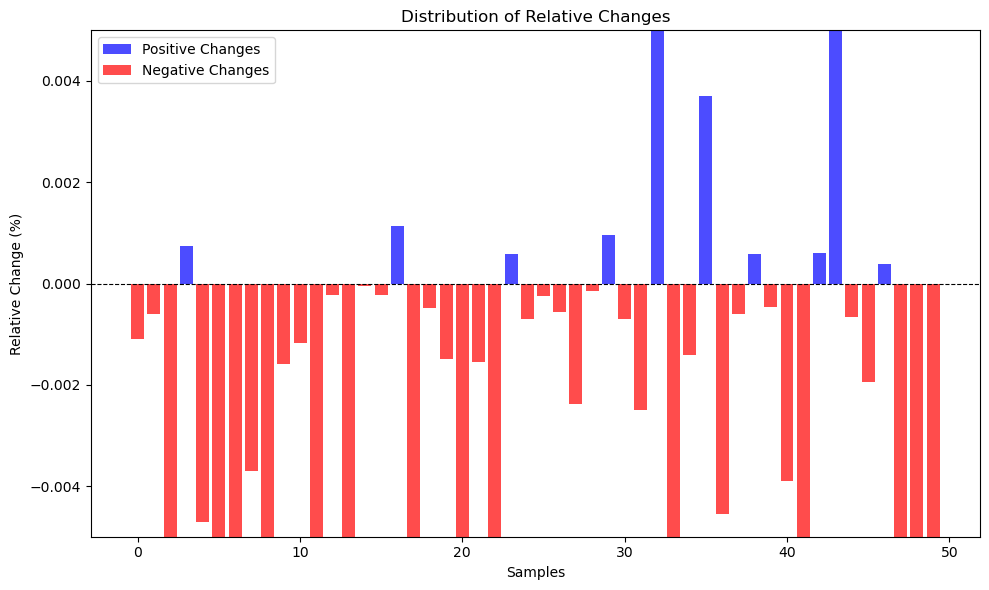


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.967
Explanations Contribution Score (ECS) of Top Tokens :  0.861
Overall Relative Change (ORC) positive changes      :  0.288 %
Overall Relative Change (ORC) negative changes      : -13.375 %


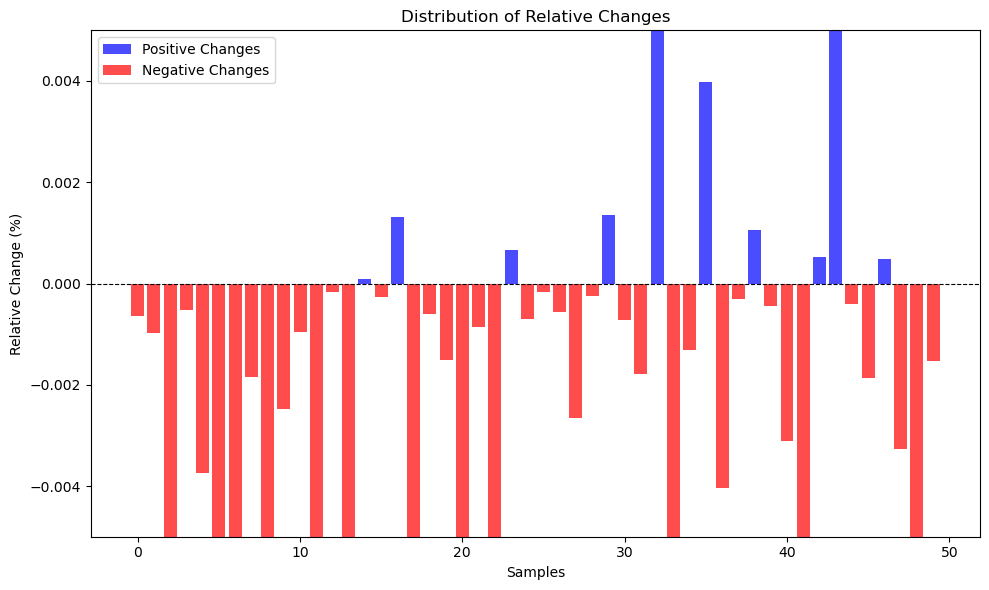


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.967
Explanations Contribution Score (ECS) of Top Tokens :  0.87
Overall Relative Change (ORC) positive changes      :  0.308 %
Overall Relative Change (ORC) negative changes      : -12.98 %


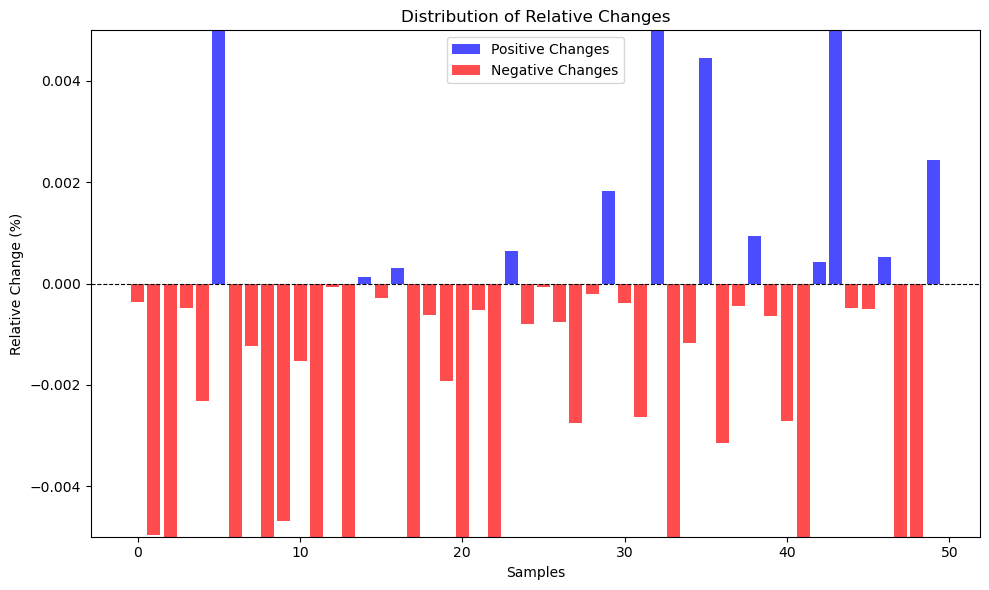

In [10]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [11]:
model_tr_news_output = create_model_output_function(bert_model_tr_news)
lig_tr_news = LayerIntegratedGradients(model_tr_news_output, bert_model_tr_news.bert.embeddings)

tr_news_bert_results = {}

for threshold in thresholds:

    ig_values_tr_news, score_vis_tr_news = apply_ig(path_ig, 
                                                    tr_news_test, 
                                                    lig_tr_news, 
                                                    bert_model_tr_news, bert_tokenizer_tr_news, 
                                                    f"ig_and_scores_tr_news_{threshold}_bert",
                                                    device, 
                                                    only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(ig_values_tr_news, bert_tokenizer_tr_news, threshold)
    
    ig_values_tr_news_short, score_vis_tr_news_short = apply_ig(path_ig, 
                                                                top_tokens_tr_news, 
                                                                lig_tr_news,
                                                                bert_model_tr_news, bert_tokenizer_tr_news,
                                                                f"ig_and_scores_tr_news_short_{threshold}_bert", 
                                                                device,
                                                                only_load=only_load)
    
    tr_news_bert_result = compare_probs(tr_news_test,
                                        bert_full_text_preds_tr_news,
                                        top_tokens_tr_news,
                                        None,
                                        bert_model_tr_news, bert_tokenizer_tr_news,
                                        id2label=bert_id2label_tr_news,
                                        device=device)

    tr_news_bert_results[threshold] = (score_vis_tr_news, score_vis_tr_news_short, tr_news_bert_result)
    
    clear_gpu_memory()
    
    show(tr_news_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_tr_news_0.5_bert' file length: 50
'ig_and_scores_tr_news_short_0.5_bert' file length: 50


'ig_and_scores_tr_news_0.6_bert' file length: 50
'ig_and_scores_tr_news_short_0.6_bert' file length: 50


'ig_and_scores_tr_news_0.7_bert' file length: 50
'ig_and_scores_tr_news_short_0.7_bert' file length: 50


In [12]:
sample_no = 33

viz.visualize_text([tr_news_bert_results[0.6][0][sample_no]])
viz.visualize_text([tr_news_bert_results[0.6][1][sample_no]])
display()


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.848
Explanations Contribution Score (ECS) of Top Tokens :  0.677
Overall Relative Change (ORC) positive changes      :  5.334 %
Overall Relative Change (ORC) negative changes      : -23.444 %


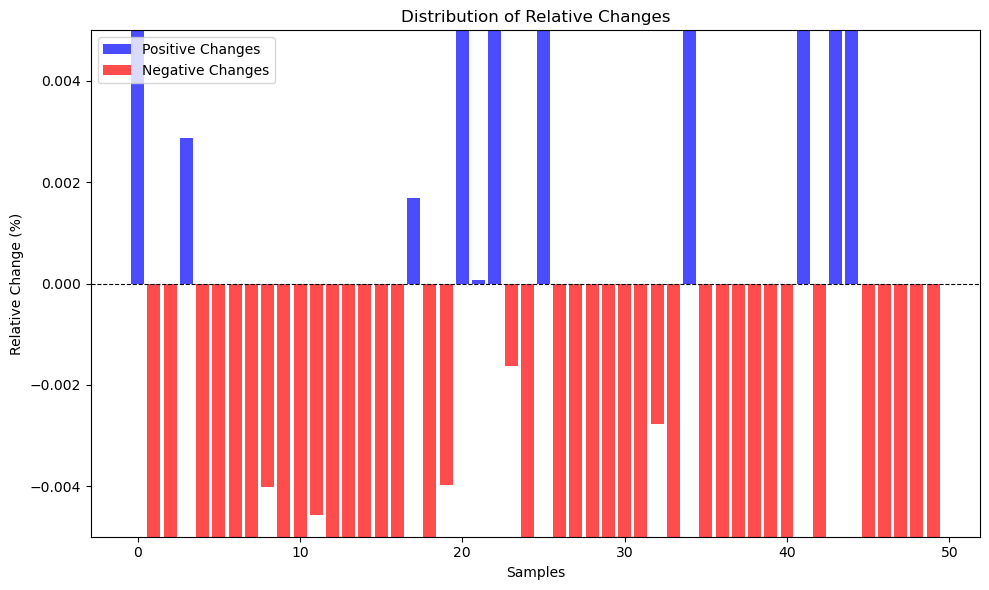


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.848
Explanations Contribution Score (ECS) of Top Tokens :  0.704
Overall Relative Change (ORC) positive changes      :  5.832 %
Overall Relative Change (ORC) negative changes      : -19.499 %


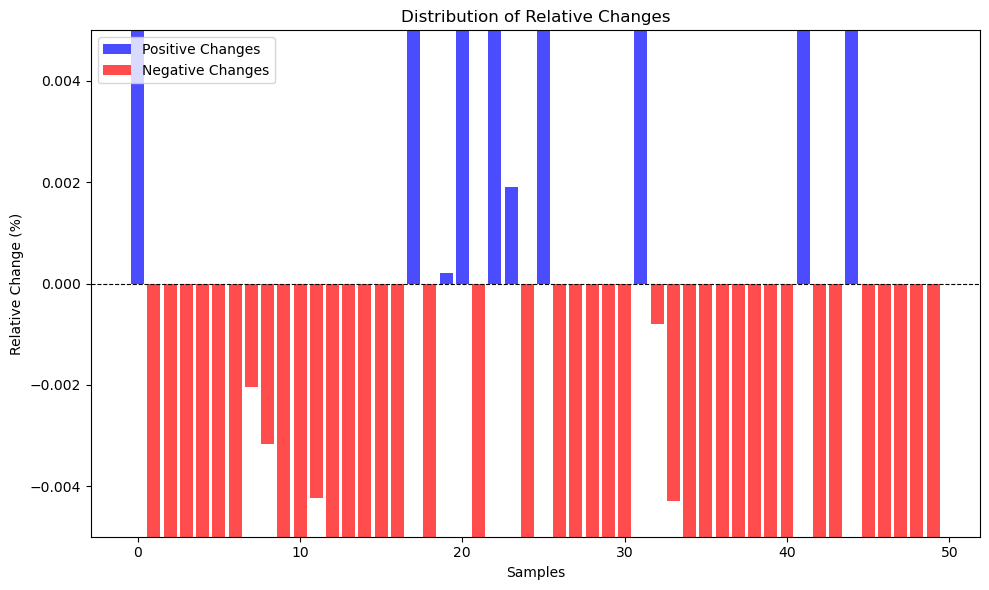


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.848
Explanations Contribution Score (ECS) of Top Tokens :  0.715
Overall Relative Change (ORC) positive changes      :  4.994 %
Overall Relative Change (ORC) negative changes      : -21.117 %


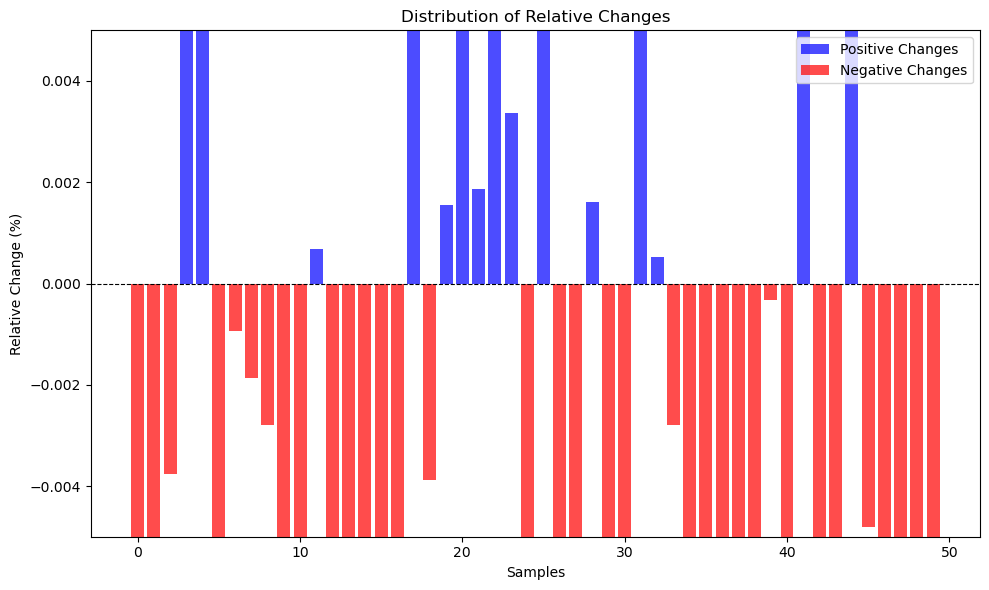

In [13]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [14]:
model_interpress_output = create_model_output_function(bert_model_interpress)
lig_interpress = LayerIntegratedGradients(model_interpress_output, bert_model_interpress.bert.embeddings)

interpress_bert_results = {}

for threshold in thresholds:

    ig_values_interpress, score_vis_interpress = apply_ig(path_ig, 
                                                          interpress_test, 
                                                          lig_interpress, 
                                                          bert_model_interpress, bert_tokenizer_interpress, 
                                                          f"ig_and_scores_interpress_{threshold}_bert",
                                                          device, 
                                                          only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(ig_values_interpress, bert_tokenizer_interpress, threshold)
    
    ig_values_interpress_short, score_vis_interpress_short = apply_ig(path_ig, 
                                                                      top_tokens_interpress, 
                                                                      lig_interpress,
                                                                      bert_model_interpress, bert_tokenizer_interpress,
                                                                      f"ig_and_scores_interpress_short_{threshold}_bert", 
                                                                      device,
                                                                      only_load=only_load)
    
    interpress_bert_result = compare_probs(interpress_test,
                                           bert_full_text_preds_interpress,
                                           top_tokens_interpress,
                                           None,
                                           bert_model_interpress, bert_tokenizer_interpress,
                                           id2label=bert_id2label_interpress,
                                           device=device)

    interpress_bert_results[threshold] = (score_vis_interpress, score_vis_interpress_short, interpress_bert_result)
    
    clear_gpu_memory()
    
    show(interpress_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_interpress_0.5_bert' file length: 50
'ig_and_scores_interpress_short_0.5_bert' file length: 50


'ig_and_scores_interpress_0.6_bert' file length: 50
'ig_and_scores_interpress_short_0.6_bert' file length: 50


'ig_and_scores_interpress_0.7_bert' file length: 50
'ig_and_scores_interpress_short_0.7_bert' file length: 50


In [15]:
sample_no = 21

viz.visualize_text([interpress_bert_results[0.6][0][sample_no]])
viz.visualize_text([interpress_bert_results[0.6][1][sample_no]])
display()


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.869
Overall Relative Change (ORC) positive changes      :  4.683 %
Overall Relative Change (ORC) negative changes      : -15.352 %


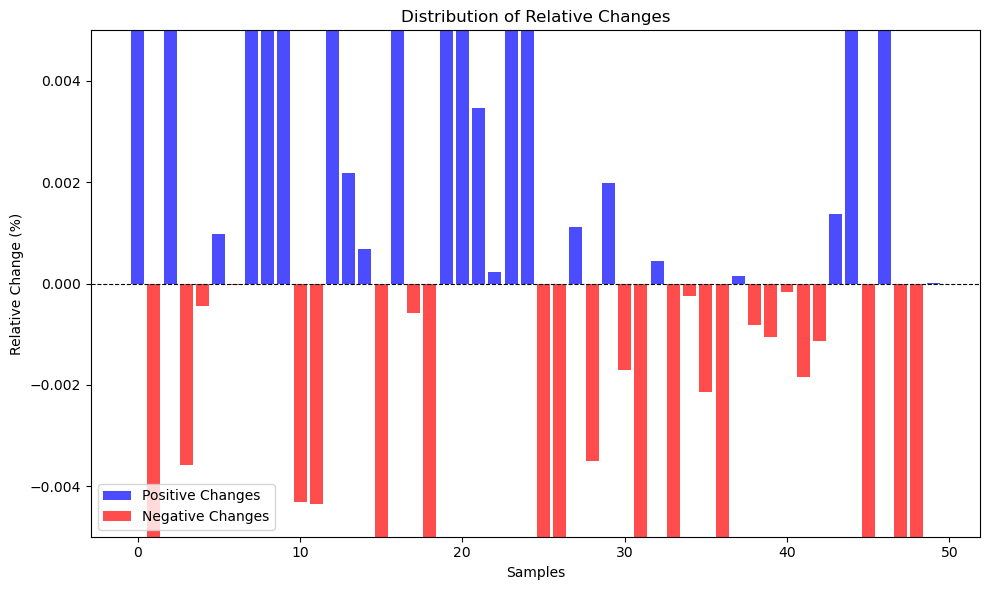


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.878
Overall Relative Change (ORC) positive changes      :  5.803 %
Overall Relative Change (ORC) negative changes      : -14.693 %


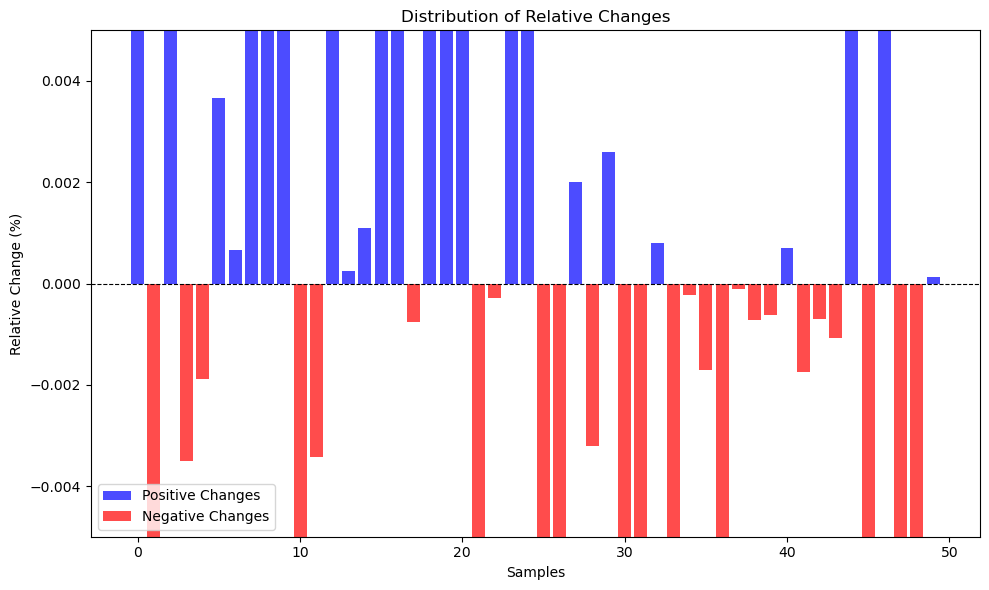


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.86
Overall Relative Change (ORC) positive changes      :  6.499 %
Overall Relative Change (ORC) negative changes      : -18.815 %


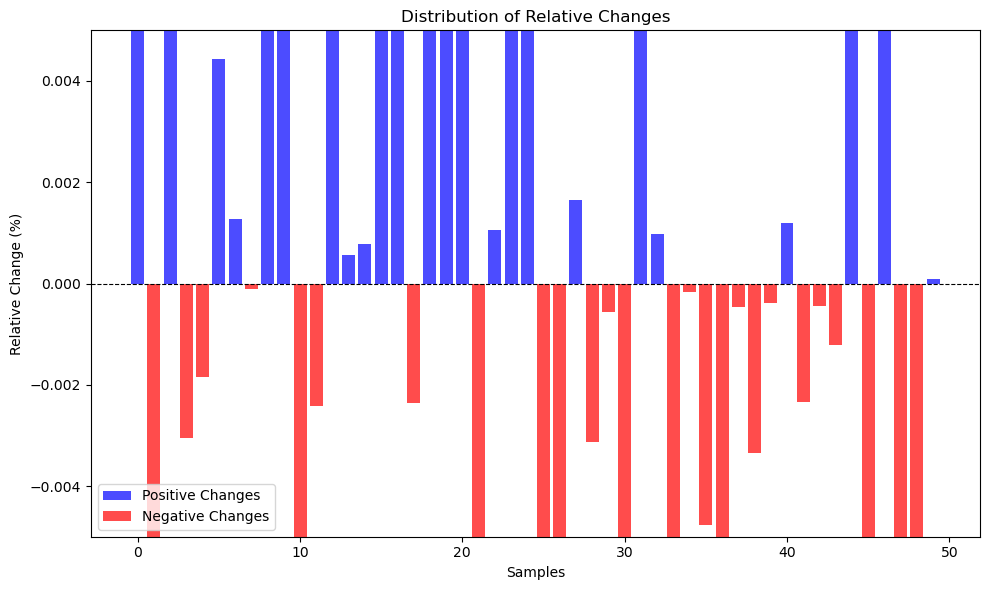

In [16]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC 32

In [17]:
model_tc32_output = create_model_output_function(bert_model_tc32)
lig_tc32 = LayerIntegratedGradients(model_tc32_output, bert_model_tc32.bert.embeddings)

tc32_bert_results = {}

for threshold in thresholds:

    ig_values_tc32, score_vis_tc32 = apply_ig(path_ig, 
                                              tc32_test, 
                                              lig_tc32, 
                                              bert_model_tc32, bert_tokenizer_tc32, 
                                              f"ig_and_scores_tc32_{threshold}_bert",
                                              device,
                                              only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(ig_values_tc32, bert_tokenizer_tc32, threshold)
    
    ig_values_tc32_short, score_vis_tc32_short = apply_ig(path_ig, 
                                                          top_tokens_tc32, 
                                                          lig_tc32,
                                                          bert_model_tc32, bert_tokenizer_tc32,
                                                          f"ig_and_scores_tc32_short_{threshold}_bert", 
                                                          device,
                                                          only_load=only_load)
    
    tc32_bert_result = compare_probs(tc32_test,
                                     bert_full_text_preds_tc32,
                                     top_tokens_tc32,
                                     None,
                                     bert_model_tc32, bert_tokenizer_tc32,
                                     id2label=bert_id2label_tc32,
                                     device=device)

    tc32_bert_results[threshold] = (score_vis_tc32, score_vis_tc32_short, tc32_bert_result)
    
    clear_gpu_memory()
    
    show(tc32_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_tc32_0.5_bert' file length: 50
'ig_and_scores_tc32_short_0.5_bert' file length: 50


'ig_and_scores_tc32_0.6_bert' file length: 50
'ig_and_scores_tc32_short_0.6_bert' file length: 50


'ig_and_scores_tc32_0.7_bert' file length: 50
'ig_and_scores_tc32_short_0.7_bert' file length: 50


In [18]:
sample_no = 41

viz.visualize_text([tc32_bert_results[0.6][0][sample_no]])
viz.visualize_text([tc32_bert_results[0.6][1][sample_no]])
display()


Classification accuracy                             :  0.94
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.785
Overall Relative Change (ORC) positive changes      :  3.105 %
Overall Relative Change (ORC) negative changes      : -24.657 %


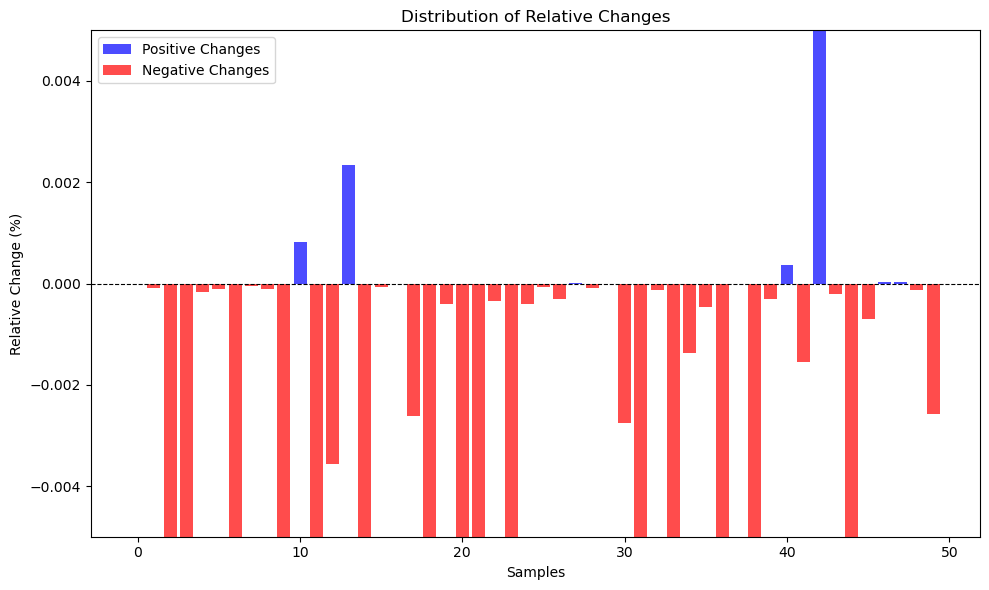


Classification accuracy                             :  0.94
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.789
Overall Relative Change (ORC) positive changes      :  3.105 %
Overall Relative Change (ORC) negative changes      : -24.164 %


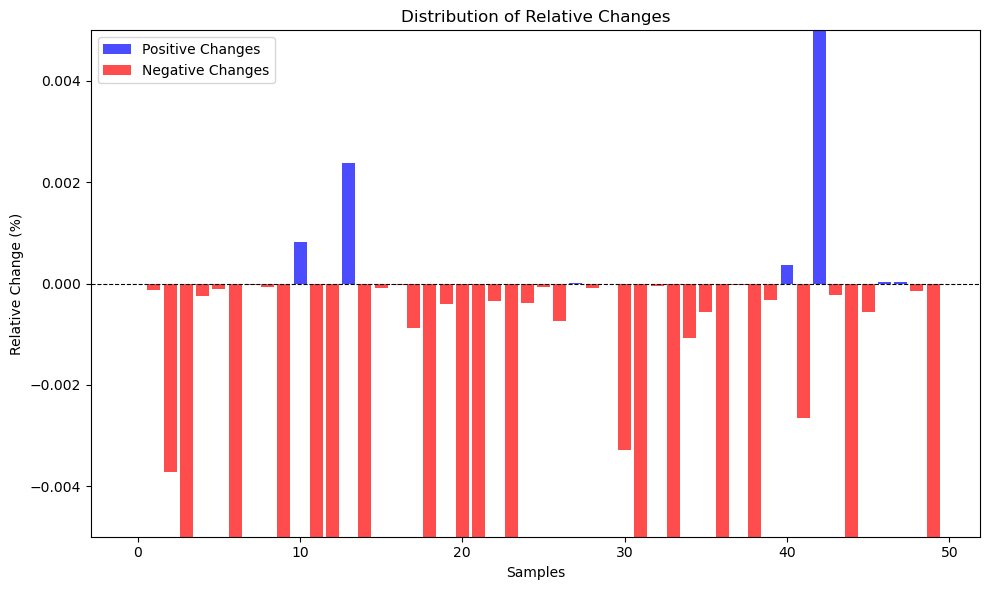


Classification accuracy                             :  0.94
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.778
Overall Relative Change (ORC) positive changes      :  2.718 %
Overall Relative Change (ORC) negative changes      : -26.045 %


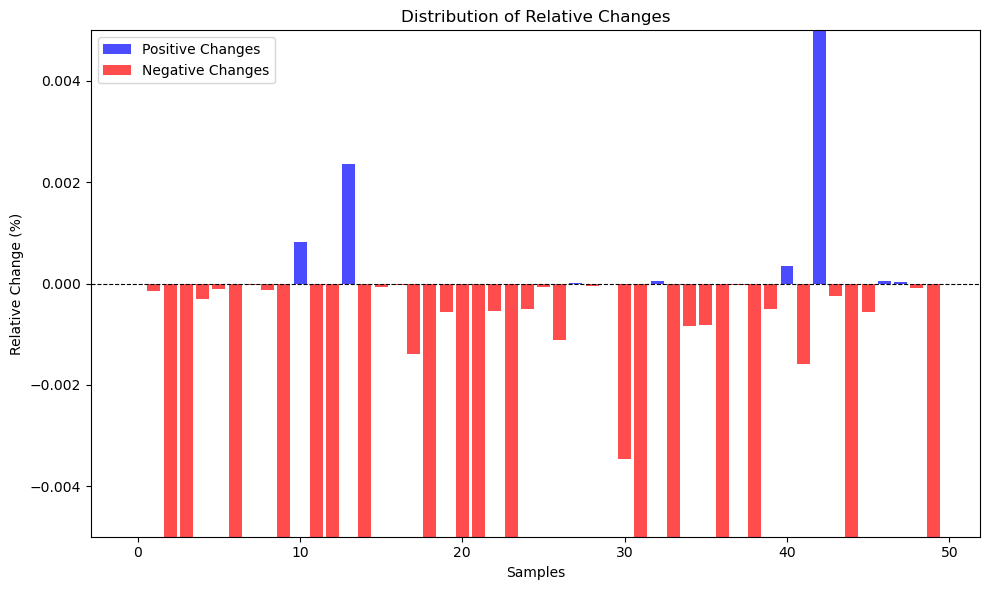

In [19]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### Inference on Full Text

In [20]:
# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)


'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


In [21]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

In [22]:
tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

#### TTC4900

In [23]:
model_ttc4900_output = create_model_output_function(tbt_model_ttc4900)
lig_ttc4900 = LayerIntegratedGradients(model_ttc4900_output, tbt_model_ttc4900.roberta.embeddings)

ttc4900_tbt_results = {}

for threshold in thresholds:

    ig_values_ttc, score_vis_ttc = apply_ig(path_ig, 
                                            ttc4900_test, 
                                            lig_ttc4900, 
                                            tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                            f"ig_and_scores_ttc_{threshold}_tbt", 
                                            device,
                                            only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(ig_values_ttc, tbt_tokenizer_ttc4900, threshold)
    
    ig_values_ttc_short, score_vis_ttc_short = apply_ig(path_ig, 
                                                        top_tokens_ttc4900, 
                                                        lig_ttc4900,
                                                        tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                                        f"ig_and_scores_ttc_short_{threshold}_tbt",
                                                        device, 
                                                        only_load=only_load)
    
    ttc4900_tbt_result = compare_probs(ttc4900_test,
                                       tbt_full_text_preds_ttc4900,
                                       top_tokens_ttc4900,
                                       None,
                                       tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                       id2label=tbt_id2label_ttc4900,
                                       device=device)

    ttc4900_tbt_results[threshold] = (score_vis_ttc, score_vis_ttc_short, ttc4900_tbt_result)
    
    clear_gpu_memory()
    
    show(ttc4900_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_ttc_0.5_tbt' file length: 50
'ig_and_scores_ttc_short_0.5_tbt' file length: 50


'ig_and_scores_ttc_0.6_tbt' file length: 50
'ig_and_scores_ttc_short_0.6_tbt' file length: 50


'ig_and_scores_ttc_0.7_tbt' file length: 50
'ig_and_scores_ttc_short_0.7_tbt' file length: 50


In [24]:
sample_no = 5

viz.visualize_text([ttc4900_tbt_results[0.6][0][sample_no]])
viz.visualize_text([ttc4900_tbt_results[0.6][1][sample_no]])
display()


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.976
Explanations Contribution Score (ECS) of Top Tokens :  0.918
Overall Relative Change (ORC) positive changes      :  1.249 %
Overall Relative Change (ORC) negative changes      : -14.646 %


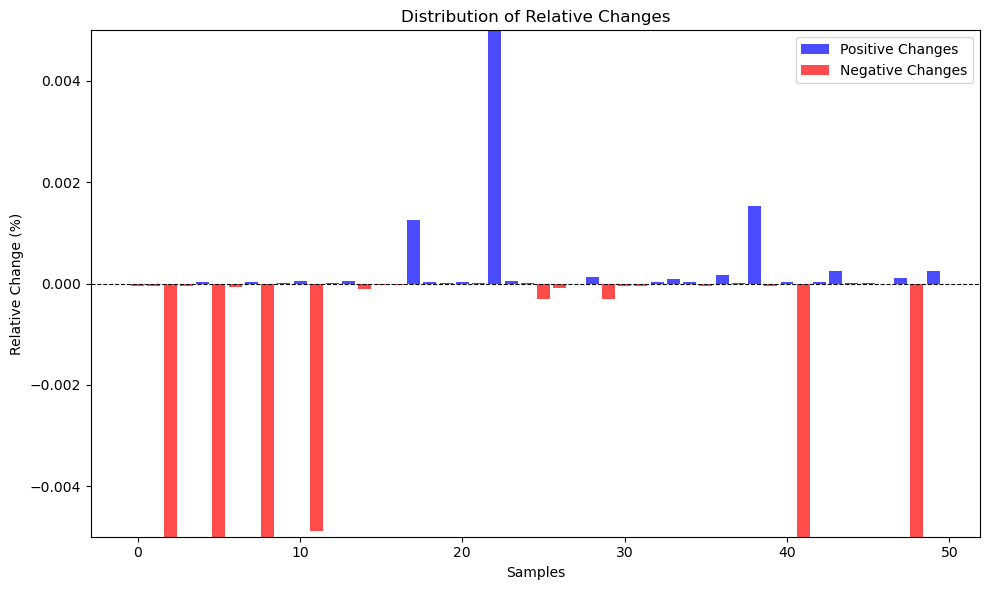


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.976
Explanations Contribution Score (ECS) of Top Tokens :  0.918
Overall Relative Change (ORC) positive changes      :  1.315 %
Overall Relative Change (ORC) negative changes      : -12.805 %


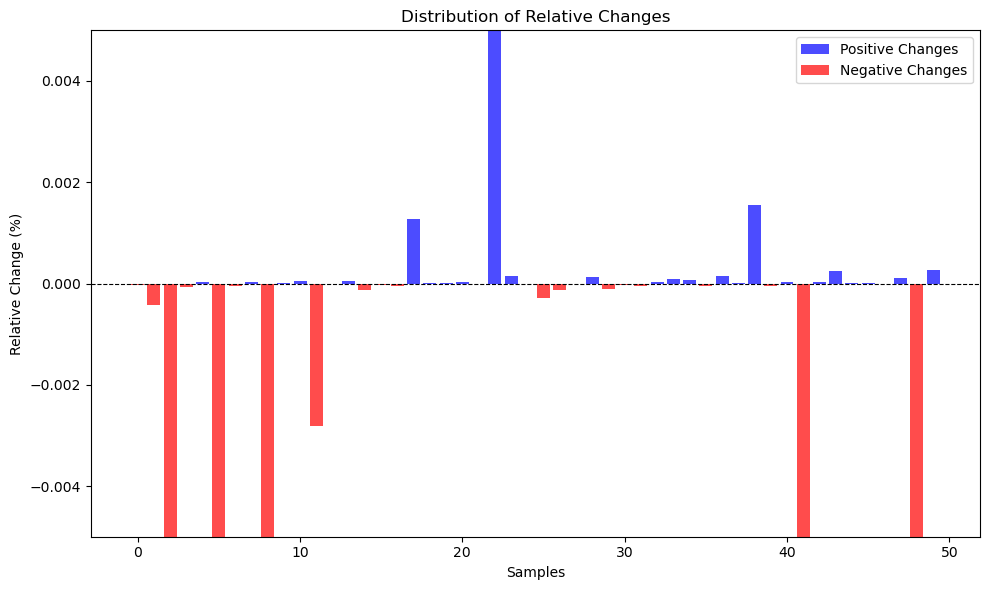


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.976
Explanations Contribution Score (ECS) of Top Tokens :  0.923
Overall Relative Change (ORC) positive changes      :  0.634 %
Overall Relative Change (ORC) negative changes      : -10.792 %


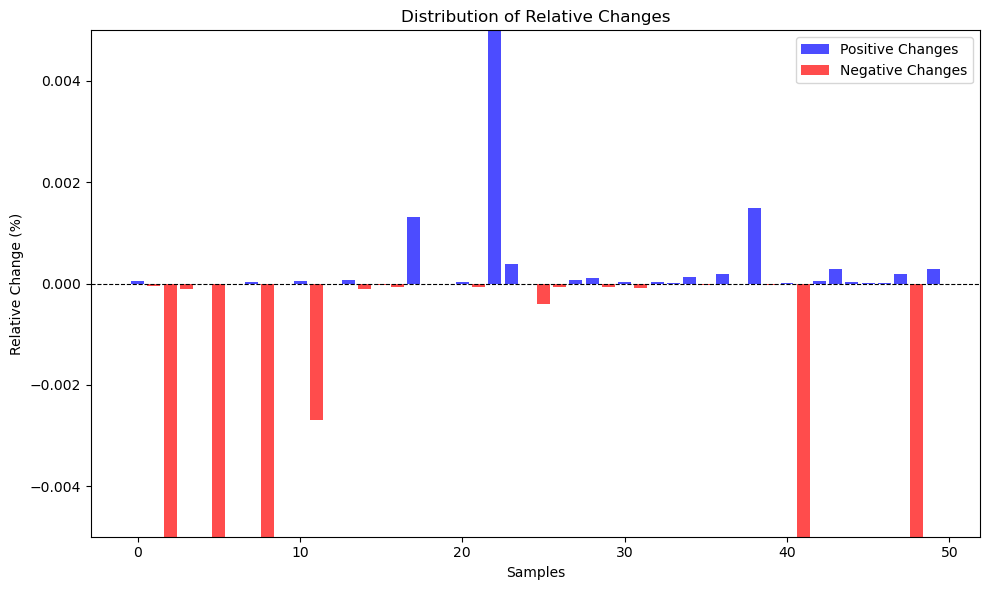

In [25]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [26]:
model_tr_news_output = create_model_output_function(tbt_model_tr_news)
lig_tr_news = LayerIntegratedGradients(model_tr_news_output, tbt_model_tr_news.roberta.embeddings)

tr_news_tbt_results = {}

for threshold in thresholds:

    ig_values_tr_news, score_vis_tr_news = apply_ig(path_ig, 
                                                    tr_news_test, 
                                                    lig_tr_news, 
                                                    tbt_model_tr_news, tbt_tokenizer_tr_news, 
                                                    f"ig_and_scores_tr_news_{threshold}_tbt",
                                                    device, 
                                                    only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(ig_values_tr_news, tbt_tokenizer_tr_news, threshold)
    
    ig_values_tr_news_short, score_vis_tr_news_short = apply_ig(path_ig, 
                                                                top_tokens_tr_news, 
                                                                lig_tr_news,
                                                                tbt_model_tr_news, tbt_tokenizer_tr_news,
                                                                f"ig_and_scores_tr_news_short_{threshold}_tbt",
                                                                device, 
                                                                only_load=only_load)
    
    tr_news_tbt_result = compare_probs(tr_news_test,
                                       tbt_full_text_preds_tr_news,
                                       top_tokens_tr_news,
                                       None,
                                       tbt_model_tr_news, tbt_tokenizer_tr_news,
                                       id2label=tbt_id2label_tr_news,
                                       device=device)

    tr_news_tbt_results[threshold] = (score_vis_tr_news, score_vis_tr_news_short, tr_news_tbt_result)
    
    clear_gpu_memory()
    
    show(tr_news_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_tr_news_0.5_tbt' file length: 50
'ig_and_scores_tr_news_short_0.5_tbt' file length: 50


'ig_and_scores_tr_news_0.6_tbt' file length: 50
'ig_and_scores_tr_news_short_0.6_tbt' file length: 50


'ig_and_scores_tr_news_0.7_tbt' file length: 50
'ig_and_scores_tr_news_short_0.7_tbt' file length: 50


In [27]:
sample_no = 2

viz.visualize_text([tr_news_tbt_results[0.6][0][sample_no]])
viz.visualize_text([tr_news_tbt_results[0.6][1][sample_no]])
display()


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.808
Explanations Contribution Score (ECS) of Top Tokens :  0.736
Overall Relative Change (ORC) positive changes      :  5.254 %
Overall Relative Change (ORC) negative changes      : -27.632 %


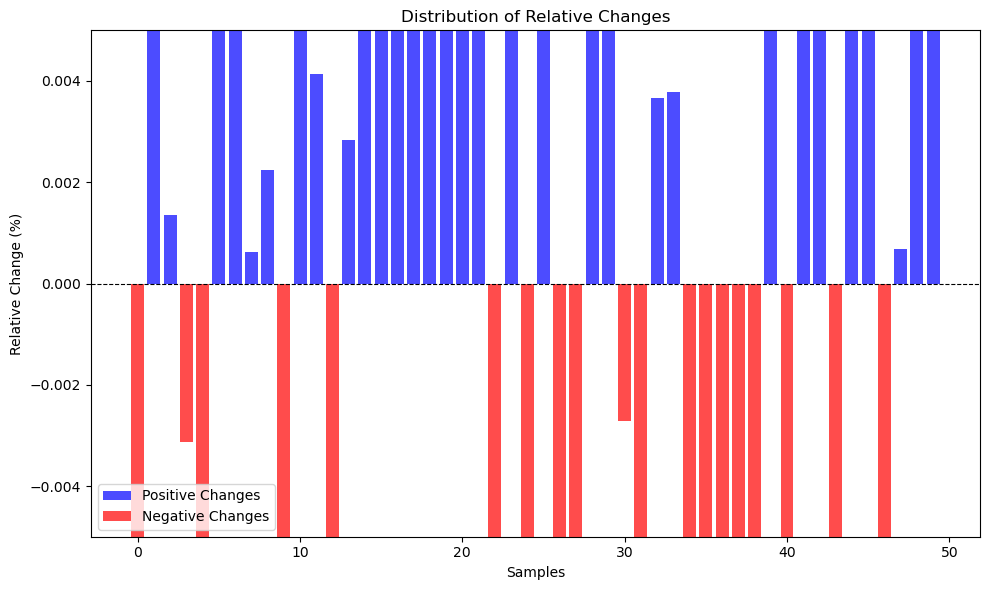


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.808
Explanations Contribution Score (ECS) of Top Tokens :  0.732
Overall Relative Change (ORC) positive changes      :  4.676 %
Overall Relative Change (ORC) negative changes      : -27.612 %


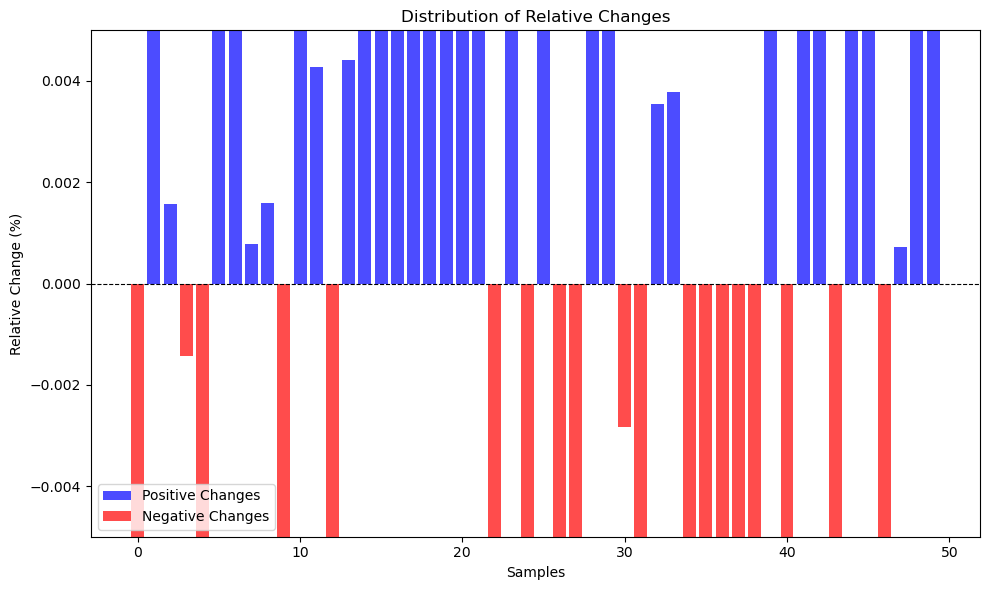


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.808
Explanations Contribution Score (ECS) of Top Tokens :  0.726
Overall Relative Change (ORC) positive changes      :  4.911 %
Overall Relative Change (ORC) negative changes      : -31.643 %


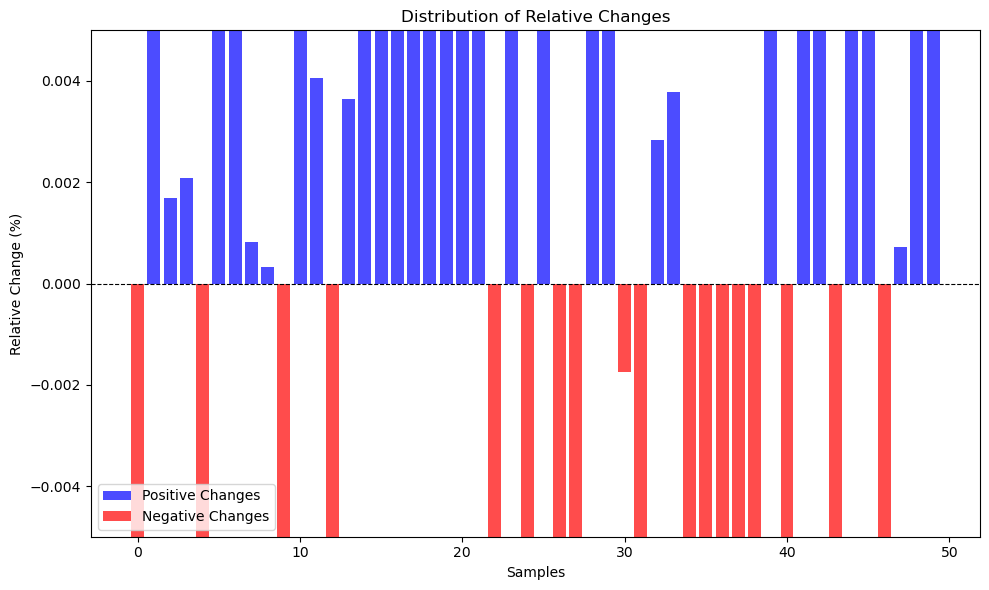

In [28]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [29]:
model_interpress_output = create_model_output_function(tbt_model_interpress)
lig_interpress = LayerIntegratedGradients(model_interpress_output, tbt_model_interpress.roberta.embeddings)

interpress_tbt_results = {}

for threshold in thresholds:

    ig_values_interpress, score_vis_interpress = apply_ig(path_ig, 
                                                          interpress_test, 
                                                          lig_interpress, 
                                                          tbt_model_interpress, tbt_tokenizer_interpress, 
                                                          f"ig_and_scores_interpress_{threshold}_tbt",
                                                          device, 
                                                          only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(ig_values_interpress, tbt_tokenizer_interpress, threshold)
    
    ig_values_interpress_short, score_vis_interpress_short = apply_ig(path_ig, 
                                                                      top_tokens_interpress, 
                                                                      lig_interpress,
                                                                      tbt_model_interpress, tbt_tokenizer_interpress,
                                                                      f"ig_and_scores_interpress_short_{threshold}_tbt",
                                                                      device, 
                                                                      only_load=only_load)
    
    interpress_tbt_result = compare_probs(interpress_test,
                                          tbt_full_text_preds_interpress,
                                          top_tokens_interpress,
                                          None,
                                          tbt_model_interpress, tbt_tokenizer_interpress,
                                          id2label=tbt_id2label_interpress,
                                          device=device)

    interpress_tbt_results[threshold] = (score_vis_interpress, score_vis_interpress_short, interpress_tbt_result)
    
    clear_gpu_memory()
    
    show(interpress_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_interpress_0.5_tbt' file length: 50
'ig_and_scores_interpress_short_0.5_tbt' file length: 50


'ig_and_scores_interpress_0.6_tbt' file length: 50
'ig_and_scores_interpress_short_0.6_tbt' file length: 50


'ig_and_scores_interpress_0.7_tbt' file length: 50
'ig_and_scores_interpress_short_0.7_tbt' file length: 50


In [30]:
sample_no = 10

viz.visualize_text([interpress_tbt_results[0.6][0][sample_no]])
viz.visualize_text([interpress_tbt_results[0.6][1][sample_no]])
display()


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.844
Explanations Contribution Score (ECS) of Top Tokens :  0.801
Overall Relative Change (ORC) positive changes      :  8.012 %
Overall Relative Change (ORC) negative changes      : -39.135 %


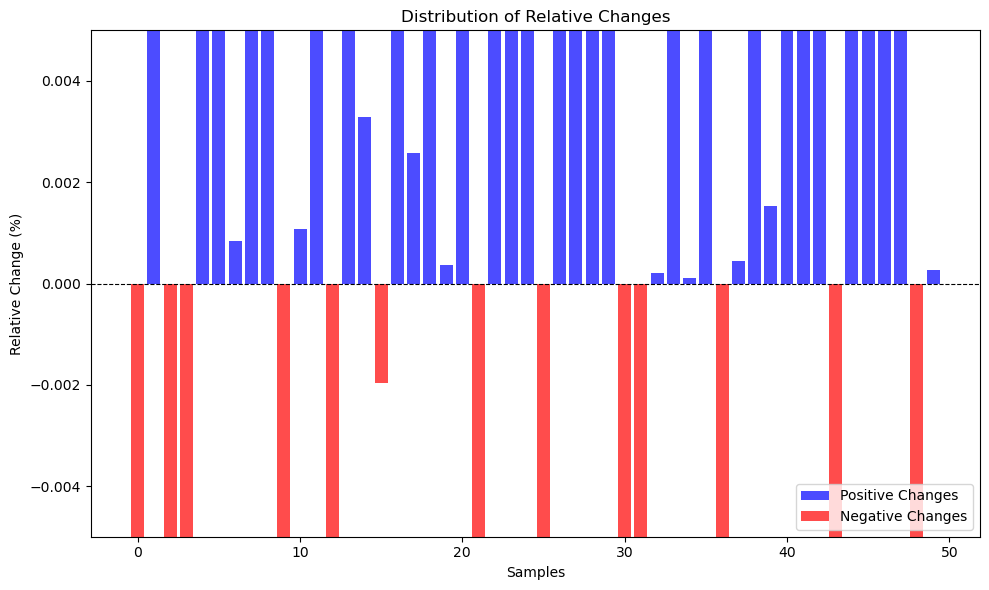


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.844
Explanations Contribution Score (ECS) of Top Tokens :  0.797
Overall Relative Change (ORC) positive changes      :  8.936 %
Overall Relative Change (ORC) negative changes      : -36.491 %


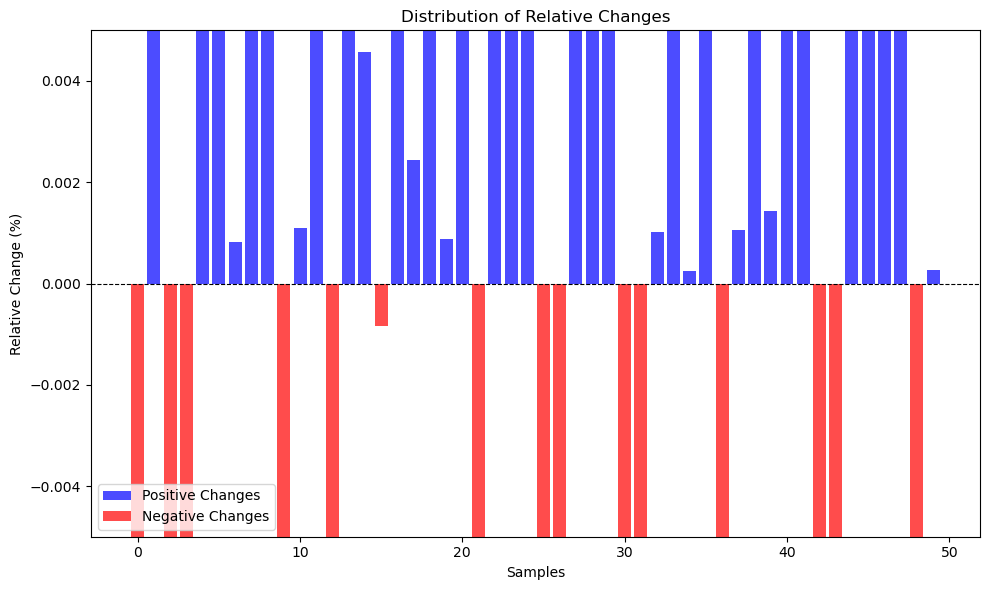


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.844
Explanations Contribution Score (ECS) of Top Tokens :  0.794
Overall Relative Change (ORC) positive changes      :  9.029 %
Overall Relative Change (ORC) negative changes      : -44.983 %


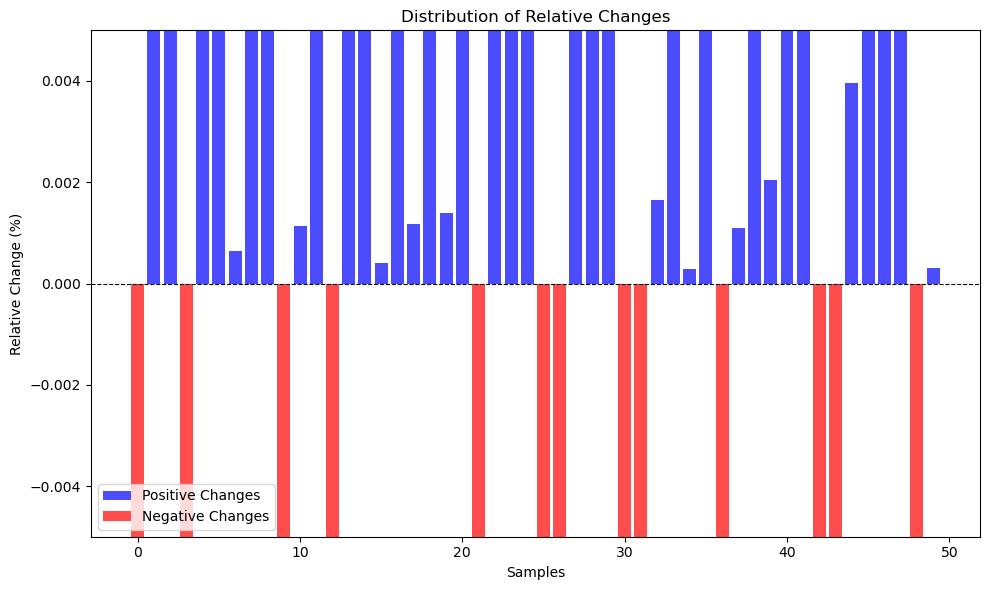

In [31]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [32]:
model_tc32_output = create_model_output_function(tbt_model_tc32)
lig_tc32 = LayerIntegratedGradients(model_tc32_output, tbt_model_tc32.roberta.embeddings)

tc32_tbt_results = {}

for threshold in thresholds:

    ig_values_tc32, score_vis_tc32 = apply_ig(path_ig, 
                                              tc32_test, 
                                              lig_tc32, 
                                              tbt_model_tc32, tbt_tokenizer_tc32, 
                                              f"ig_and_scores_tc32_{threshold}_tbt",
                                              device, 
                                              only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(ig_values_tc32, tbt_tokenizer_tc32, threshold)
    
    ig_values_tc32_short, score_vis_tc32_short = apply_ig(path_ig, 
                                                          top_tokens_tc32, 
                                                          lig_tc32,
                                                          tbt_model_tc32, tbt_tokenizer_tc32,
                                                          f"ig_and_scores_tc32_short_{threshold}_tbt",
                                                          device, 
                                                          only_load=only_load)
    
    tc32_tbt_result = compare_probs(tc32_test,
                                    tbt_full_text_preds_tc32,
                                    top_tokens_tc32,
                                    None,
                                    tbt_model_tc32, tbt_tokenizer_tc32,
                                    id2label=tbt_id2label_tc32,
                                    device=device)

    tc32_tbt_results[threshold] = (score_vis_tc32, score_vis_tc32_short, tc32_tbt_result)
    
    clear_gpu_memory()
    
    show(tc32_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_tc32_0.5_tbt' file length: 50
'ig_and_scores_tc32_short_0.5_tbt' file length: 50


'ig_and_scores_tc32_0.6_tbt' file length: 50
'ig_and_scores_tc32_short_0.6_tbt' file length: 50


'ig_and_scores_tc32_0.7_tbt' file length: 50
'ig_and_scores_tc32_short_0.7_tbt' file length: 50


In [33]:
sample_no = 19

viz.visualize_text([tc32_tbt_results[0.6][0][sample_no]])
viz.visualize_text([tc32_tbt_results[0.6][1][sample_no]])
display()


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.942
Explanations Contribution Score (ECS) of Top Tokens :  0.827
Overall Relative Change (ORC) positive changes      :  6.792 %
Overall Relative Change (ORC) negative changes      : -17.262 %


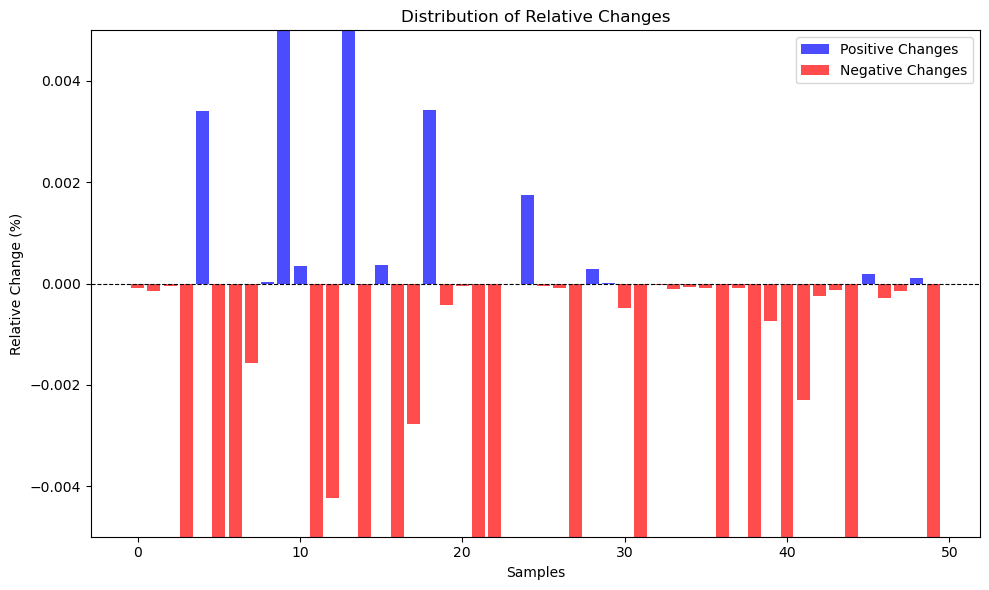


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.942
Explanations Contribution Score (ECS) of Top Tokens :  0.835
Overall Relative Change (ORC) positive changes      :  8.373 %
Overall Relative Change (ORC) negative changes      : -16.71 %


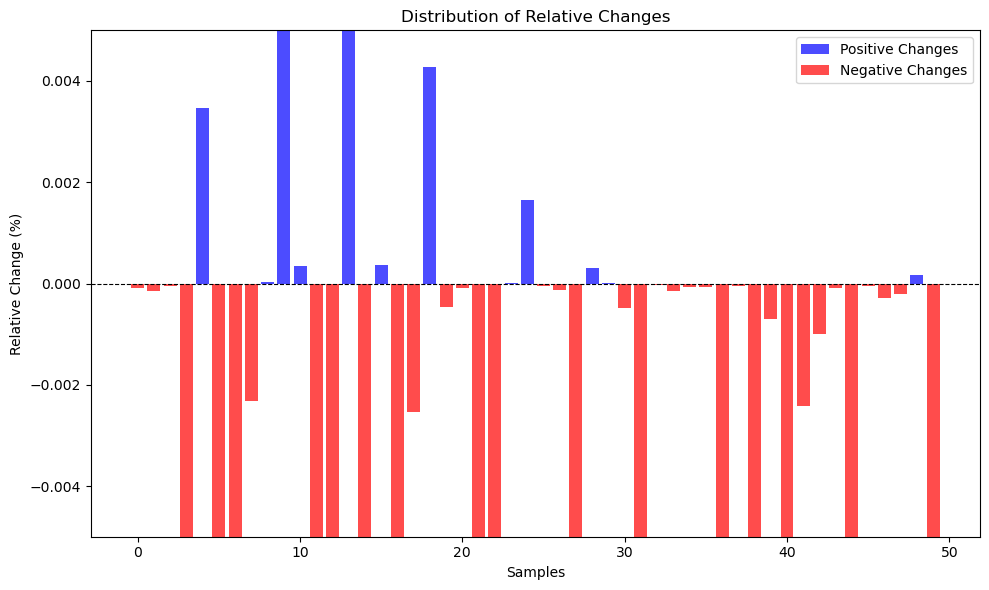


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.942
Explanations Contribution Score (ECS) of Top Tokens :  0.837
Overall Relative Change (ORC) positive changes      :  8.855 %
Overall Relative Change (ORC) negative changes      : -16.646 %


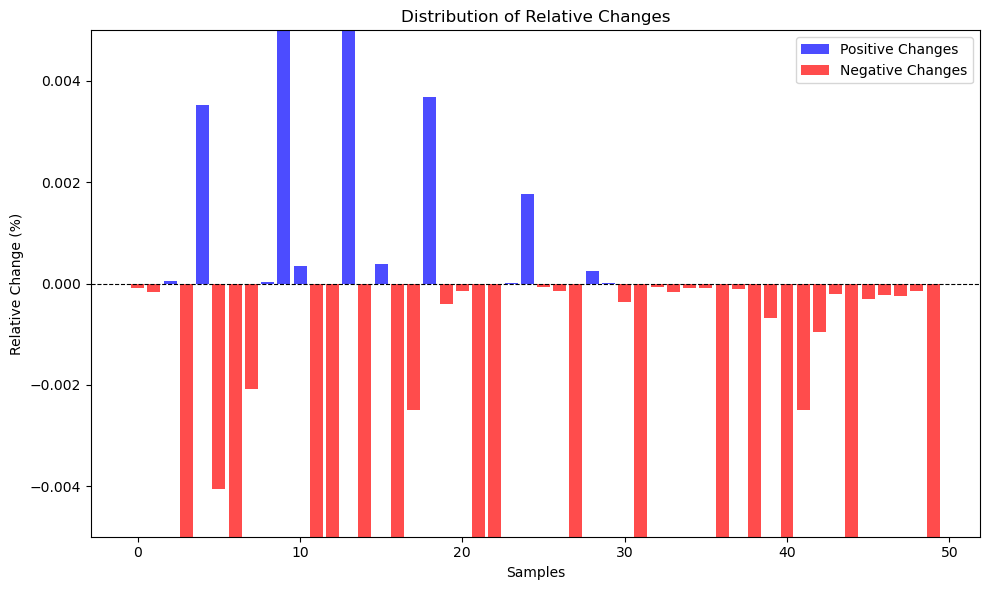

In [34]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

## Final Results

In [35]:
all_exp_results

,Cl Acc,ECS FT,ECS TT,ORC (+),ORC (-)
0,0.88,0.967,0.874,0.256,-11.777
1,0.88,0.967,0.861,0.288,-13.375
2,0.88,0.967,0.870,0.308,-12.980
3,0.78,0.848,0.677,5.334,-23.444
4,0.78,0.848,0.704,5.832,-19.499
5,0.78,0.848,0.715,4.994,-21.117
6,0.88,0.927,0.869,4.683,-15.352
7,0.88,0.927,0.878,5.803,-14.693
8,0.88,0.927,0.860,6.499,-18.815
9,0.94,0.993,0.785,3.105,-24.657


In [36]:
excel_file = path_reports + 'all_exp_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
    all_exp_results.to_excel(writer, sheet_name='IG', index=False)